In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import emcee
import corner
from scipy.optimize import minimize
from IPython.display import Math

import model_transits

In [2]:
data_arr = np.load('/Users/eligendreaudistler/Desktop/wd-1856-534b/arrays/data_arr.npy', allow_pickle=True)

dates = ['2022-04-01', '2022-06-02', '2023-07-31', '2023-08-14', '2024-05-13', 
         '2024-06-06', '2024-06-13', '2024-06-23', '2024-06-30', '2024-07-07',
         '2024-07-14', '2024-07-24', '2024-08-07', '2024-08-14', '2025-05-17',
         '2025-05-24']

start = np.array([11,  5, 20, 21, 30, 38, 21, 30, 42, 41, 28, 44, 42, 37, 10, 23])
mid =   np.array([14,  8, 23, 25, 33, 41, 25, 34, 46, 45, 31, 47, 46, 40, 13, 26])
end =   np.array([17, 10, 26, 28, 36, 44, 28, 37, 49, 48, 34, 51, 49, 44, 17, 29])

i = 12

In [3]:
period = 1.4079405 # from NASA Exoplanet Archive
times = np.arange(data_arr[i]['BJD_TDB'].iloc[0], data_arr[i]['BJD_TDB'].iloc[-1], 0.0001)

In [4]:
# initial guesses
t0_arr = np.array([0.0094, 0.9587, 0.7488, 0.8282, 0.9687, 0.9037, 0.9434, 0.7990, 0.8387, 0.8784, 0.9181, 0.7737, 0.8531, 0.8928, 0.8491, 0.8888]) # from Swarthmore
t0_init = t0_arr[i]
b_init = 7.16 # from Vanderburg
r_a_init = 0.002986 # calculated as 0.01310 R✶(R⦿) x (0.00465047 au / 1 R⦿) x (1 orbital distance / 0.0204 au), both intermediate values from Vanderburg
Rp_Rs_init = 7.28 # from Vanderburg
u1 = 0.72811524 if i==0 else 0.58066800 # varies by filter
u2 = 0.057518913 if i==0 else 0.14288800

m_init = 0.1
c_init = 0.0
log_f_init = np.log(0.01)
theta_initial = np.array([t0_init, b_init, r_a_init, Rp_Rs_init, m_init, c_init, log_f_init])

In [ ]:
def plot_lightcurve(data, title, theta=None):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    title_size = 20
    fontsize = 15

    rel_flux_key = 'rel_flux_T1_normalized'
    rel_flux_err_key = 'rel_flux_err_T1_normalized'

    ax.errorbar(data['BJD_TDB'], data[rel_flux_key], linewidth=1.5,
                linestyle='solid', marker='o', markersize=4, elinewidth=0.5,
                yerr=data[rel_flux_err_key], capsize=2, color='crimson')
    ax.set_title(title, fontsize=title_size, y=1.01)

    if theta is not None:
        t0, b, r_a, Rp_Rs, m, c, log_f = theta
        model = model_transits.modeltransit([t0, b, r_a, Rp_Rs, 1, u1, u2], model_transits.occultquad, period, times)
        plt.plot(times, model, markersize=2, color='black')

    ax.set_ylabel('Relative Flux', fontsize=fontsize)
    ax.set_xlabel('BJD TDB', fontsize=fontsize)

/Users/eligendreaudistler/Desktop/wd-1856-534b/fit_lightcurves/model_transits.py:852: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


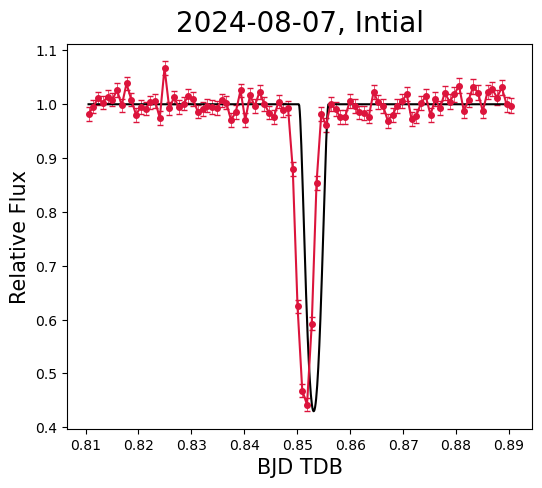

In [6]:
plot_lightcurve(data_arr[i], '{}, Intial'.format(dates[i]), theta=theta_initial)

Maximum likelihood estimates:
t0 = 0.85145
b = 5.58324
r_a = 1.00355
Rp_Rs = 299.71011
m = 1.03048
c = 0.97507
f = 0.01272


/Users/eligendreaudistler/Desktop/wd-1856-534b/fit_lightcurves/model_transits.py:852: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%
/Users/eligendreaudistler/Desktop/wd-1856-534b/fit_lightcurves/model_transits.py:852: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


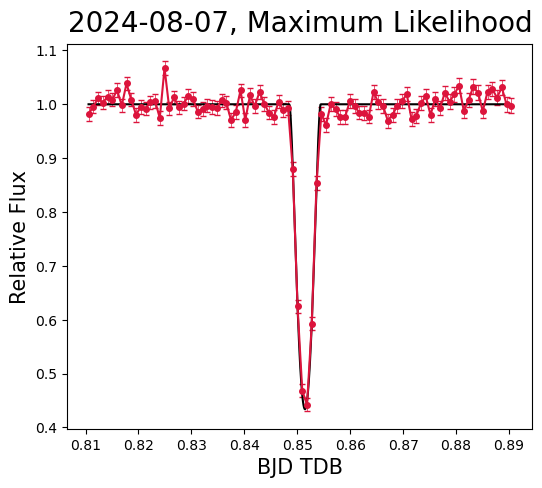

In [7]:
# likelihood function for Gaussian distribution with variance underestimated by fractional amount f (https://emcee.readthedocs.io/en/stable/tutorials/line/)
def log_likelihood(theta, x, y, yerr): # x = time, y = rel_flux
    t0, b, r_a, Rp_Rs, m, c, log_f = theta
    model = model_transits.modeltransit([t0, b, r_a, Rp_Rs, 1, u1, u2], model_transits.occultquad, period, x) + (m*x + c)
    sigma2 = yerr**2 + model**2 * np.exp(2*log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

# negative log likelihood function
nll = lambda *args: -log_likelihood(*args)

soln = minimize(nll, theta_initial, args=(data_arr[i]['BJD_TDB'], data_arr[i]['rel_flux_T1_normalized'], data_arr[i]['rel_flux_err_T1_normalized']))

theta_ml = soln.x
t0_ml, b_ml, r_a_ml, Rp_Rs_ml, m_ml, c_ml, log_f_ml = theta_ml

print("Maximum likelihood estimates:")
print("t0 = {0:.5f}".format(t0_ml))
print("b = {0:.5f}".format(b_ml))
print("r_a = {0:.5f}".format(np.exp(r_a_ml)))
print("Rp_Rs = {0:.5f}".format(np.exp(Rp_Rs_ml)))
print("m = {0:.5f}".format(np.exp(m_ml)))
print("c = {0:.5f}".format(np.exp(c_ml)))
print("f = {0:.5f}".format(np.exp(log_f_ml)))

plot_lightcurve(data_arr[i], '{}, Maximum Likelihood'.format(dates[i]), theta=theta_ml)

In [8]:
# uniform priors on all parameters
def log_prior(theta):
    t0, b, r_a, Rp_Rs, m, c, log_f = theta
    if (data_arr[i]['BJD_TDB'][start[i]] < t0 < data_arr[i]['BJD_TDB'][end[i]] \
        and 2.15 < b < 12.15 and 0 < r_a < 0.006 and 2.3 < Rp_Rs < 12.3 \
        and -0.1 < m < 0.1 and -5.0 < c < 5.0 and -10 < log_f < 10): 
        return 0.0
    return -np.inf

In [9]:
def log_probability(theta, x, y, yerr): # x = time, y = flux
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [10]:
# MCMC will not run because ML values are too far from actual values
# to fix this, set guess solution based on past transits and expected values
soln.x = t0_init, 7.16, 0.003, 7.28, 0.0001, 0.0001, -6.0

In [11]:
# initialize walkers in tiny Gaussian ball around ML soln
pos = soln.x + np.array([0.0001, 0.3, 0.0002, 0.3, 0.05, 0.05, 1]) * np.random.randn(32, 7) # 32 walkers, 7 dimensions
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(data_arr[i]['BJD_TDB'], 
                                data_arr[i]['rel_flux_T1_normalized'], data_arr[i]['rel_flux_err_T1_normalized']))

sampler.run_mcmc(pos, 5_000, progress=True);

100%|██████████| 5000/5000 [03:36<00:00, 23.10it/s]


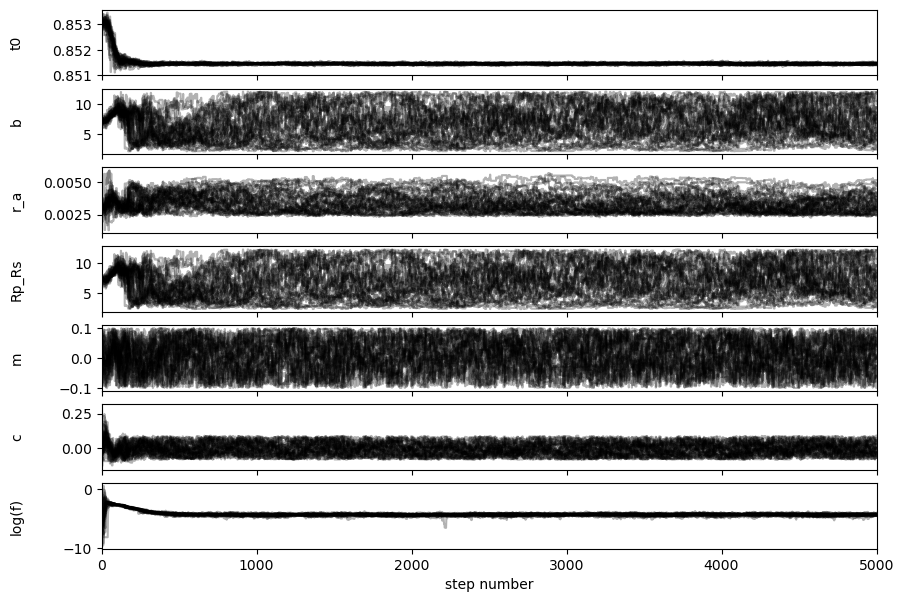

In [12]:
fig, axes = plt.subplots(7, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['t0', 'b', 'r_a', 'Rp_Rs', 'm', 'c', 'log(f)']
for j in range(ndim):
    ax = axes[j]
    ax.plot(samples[:,:,j],"k",alpha=0.3)
    ax.set_xlim(0,len(samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1,0.5)
    
axes[-1].set_xlabel("step number");

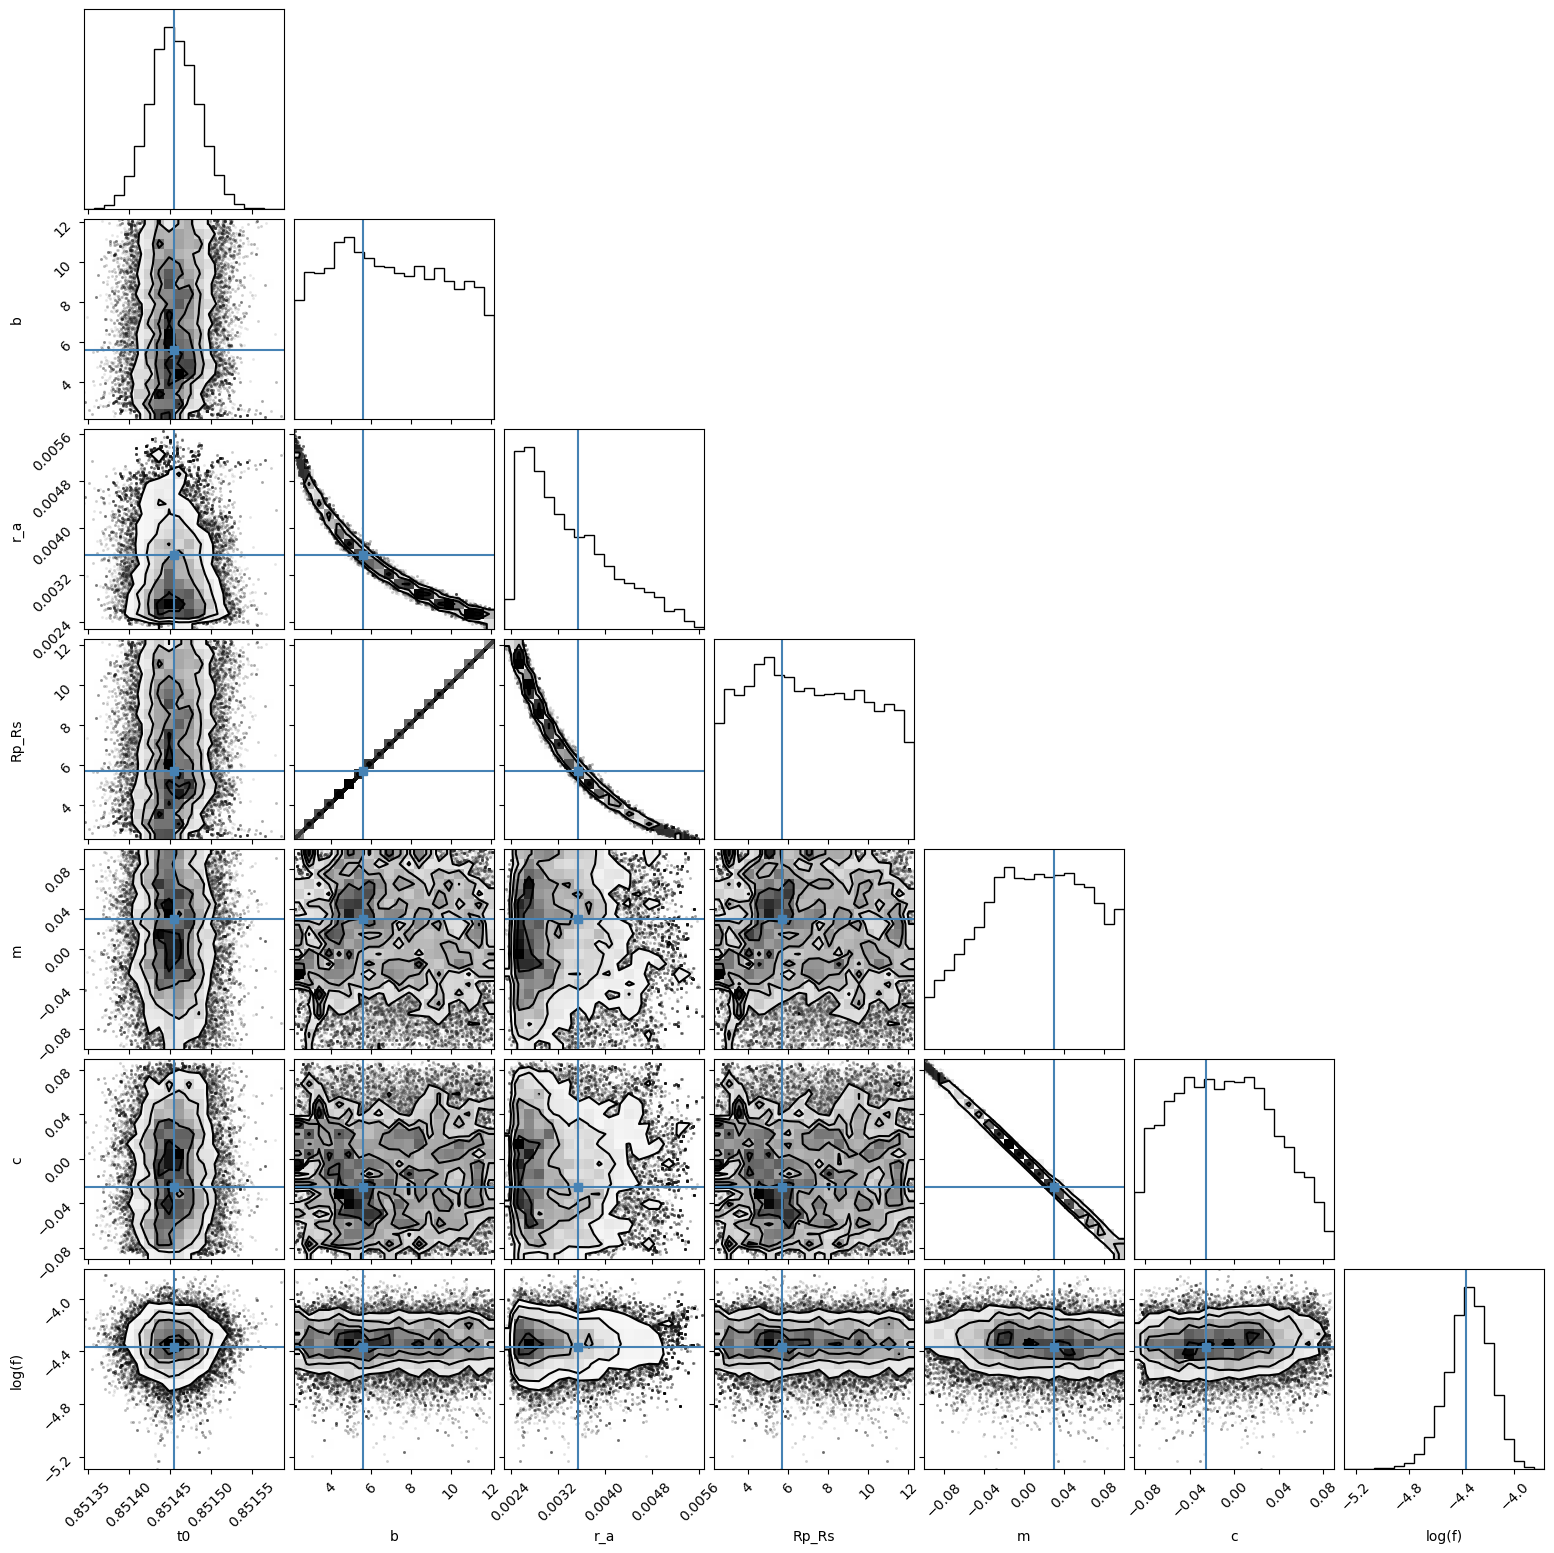

In [13]:
flat_samples = sampler.get_chain(discard=2_500, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths = [t0_ml, b_ml, r_a_ml, Rp_Rs_ml, m_ml, c_ml, log_f_ml]
);

In [14]:
# compute parameters to cite
# here use 16th, 50th, and 84th percentiles
for j in range(ndim):
    mcmc = np.percentile(flat_samples[:,j],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[j])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[ 8.51454098e-01  6.86411808e+00  3.21950773e-03  6.97566107e+00
  1.16464913e-02 -9.52526845e-03 -4.33868014e+00]


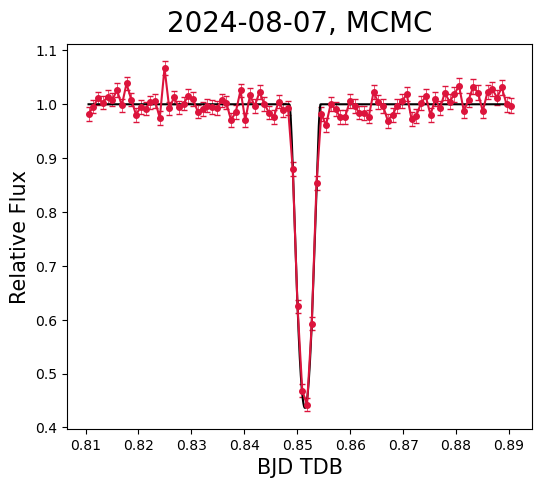

In [15]:
theta_mcmc = []
for j in np.arange(ndim):
    k = np.median(flat_samples[:, j])
    theta_mcmc = np.append(theta_mcmc, k)

print(theta_mcmc)

plot_lightcurve(data_arr[i], '{}, MCMC'.format(dates[i]), theta=theta_mcmc)

In [16]:
t0, b, r_a, Rp_Rs, m, c, log_f = theta_mcmc
correction = m*data_arr[i]['BJD_TDB'] + c
detrend = data_arr[i]['rel_flux_T1_normalized'] - correction
model = model_transits.modeltransit([t0, b, r_a, Rp_Rs, 1, u1, u2], model_transits.occultquad, period, data_arr[i]['BJD_TDB'])
res = detrend - model

Text(0.5, 0.98, 'WD 1856+534 b, 2024-08-07')

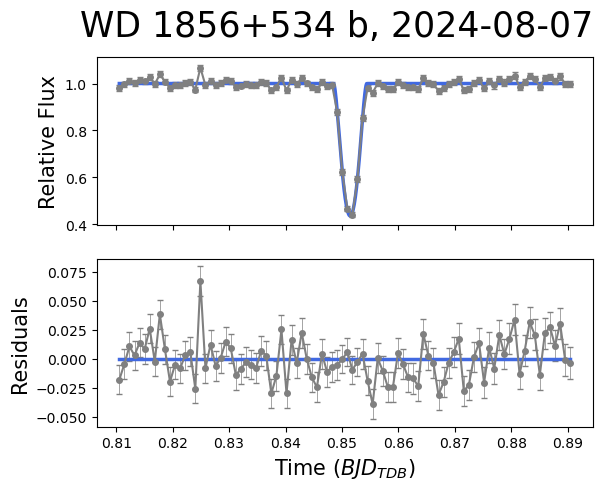

In [17]:
model_times = model_transits.modeltransit([t0, b, r_a, Rp_Rs, 1, u1, u2], model_transits.occultquad, period, times)

fig, ax = plt.subplots(2,sharex=True)

ax[0].errorbar(data_arr[i]['BJD_TDB'], detrend, yerr=data_arr[i]['rel_flux_err_T1_normalized'], linestyle='solid', linewidth=1.5, marker='o', 
               markersize=4, elinewidth=0.5, capsize=2, color='grey')
ax[0].plot(times, model_times, color='royalblue', linewidth=2.5)

ax[1].errorbar(data_arr[i]['BJD_TDB'], res, yerr=data_arr[i]['rel_flux_err_T1_normalized'], linestyle='solid', linewidth=1.5, marker='o', 
               markersize=4, elinewidth=0.5, capsize=2, color='grey')
ax[1].plot([data_arr[i]['BJD_TDB'].iloc[0], data_arr[i]['BJD_TDB'].iloc[-1]], [0, 0], color='royalblue', linewidth=2.5)

plt.xlabel("Time $(BJD_{TDB})$", fontsize=15)
ax[0].set_ylabel("Relative Flux", fontsize=15)
ax[1].set_ylabel("Residuals", fontsize=15)
fig.suptitle('WD 1856+534 b, {}'.format(dates[i]), fontsize=25)

In [18]:
arr_dir = '/Users/eligendreaudistler/Desktop/wd-1856-534b/arrays'
np.save(os.path.join(arr_dir, 'theta_mcmc_{}.npy'.format(dates[i])), theta_mcmc)